In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.ticker as mticker

from matplotlib.dates import DateFormatter
from datetime import timedelta

billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")
billboard_hot_100["top_position"] = billboard_hot_100.groupby(["artist", "song_name"])["position"].transform("min")

C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\3412998217.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\3322084532.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(
C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\3322084532.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(


In [4]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])[["position", "first_day_of_the_week"]].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])[["position", "first_day_of_the_week"]].transform("last")["position"]

billboard_hot_100_copy = billboard_hot_100.copy()
billboard_hot_100_ml = billboard_hot_100.groupby(
    ["artist", "song_name"])[["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "year", "first_position", "last_position"]].first().reset_index()

In [5]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

In [6]:
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from pandas.plotting import table

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(billboard_hot_100_ml[features])

model = KMeans(n_clusters=5, n_init="auto", random_state=1)
model.fit(X)

y_clusters = model.predict(X)

billboard_hot_100_ml["cluster"] = y_clusters
billboard_hot_100_new = billboard_hot_100_ml[["artist", "song_name", "cluster"]].merge(billboard_hot_100_copy, on=["artist", "song_name"], how="left")

from numpy import unique

unique_clusters = unique(y_clusters)

In [8]:
# classify clusters
cluster_statistics = {}

for cluster in unique_clusters:
    songs_from_cluster = billboard_hot_100_new[billboard_hot_100_new['cluster'] == cluster].copy()
    cluster_statistics[cluster] = songs_from_cluster[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()

brief_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
start_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["first_position"] for i in unique_clusters])
end_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["future_weeks"] for i in unique_clusters])
normal_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
longlasting_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
print("Brief " + str(brief_cluster))
print("High-start " + str(start_high_cluster))
print("High-end " + str(end_high_cluster))
print("Normal " + str(normal_cluster))
print("Long-lasting " + str(longlasting_cluster))

Brief 0
High-start 1
High-end 2
Normal 4
Long-lasting 3


In [9]:
def map_cluster_name(cluster_nr):
    if cluster_nr == brief_cluster:
        return "Brief"
    if cluster_nr == start_high_cluster:
        return "High-start"
    if cluster_nr == end_high_cluster:
        return "High-end"
    if cluster_nr == normal_cluster:
        return "Climbing"
    return "Long-lasting"

billboard_hot_100_new["cluster"] = billboard_hot_100_new["cluster"].map(lambda x: map_cluster_name(x))

In [10]:
rows_to_add = []

grouped = billboard_hot_100_new.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + timedelta(weeks=1)

            while week <= (max_week + timedelta(weeks=50)):
                rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_position": row["first_position"],
                    "last_position": row["last_position"],
                    "past_weeks": row["past_weeks"],
                    "future_weeks": row["future_weeks"],
                    "max_weeks_on_chart": row["max_weeks_on_chart"],
                    "cluster": row["cluster"],
                    "year": row["year"]
                })
                week += timedelta(weeks=1)

billboard_100_with_empty_weeks_ml = pd.concat([billboard_hot_100_new[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "top_position",
    "first_position", "last_position", "past_weeks", "future_weeks",
    "max_weeks_on_chart", "cluster", "year"]], pd.DataFrame(rows_to_add)], ignore_index=True)
billboard_100_with_empty_weeks_ml["first_week"] = billboard_100_with_empty_weeks_ml.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

100%|██████████| 30147/30147 [01:23<00:00, 361.78it/s]


In [11]:
# MTV Launch date
mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)

# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

# iTunes release date
itunes_creation_date = pd.to_datetime("2001-01-09", infer_datetime_format=True)

# Cassettes creation date
cassettes_creation_date = pd.to_datetime("1963-08-30", infer_datetime_format=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\1792693761.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)
C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\1792693761.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)
C:\Users\cutie\AppData\Local\Temp\ipykernel_33592\1792693761.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict

<Figure size 600x400 with 0 Axes>

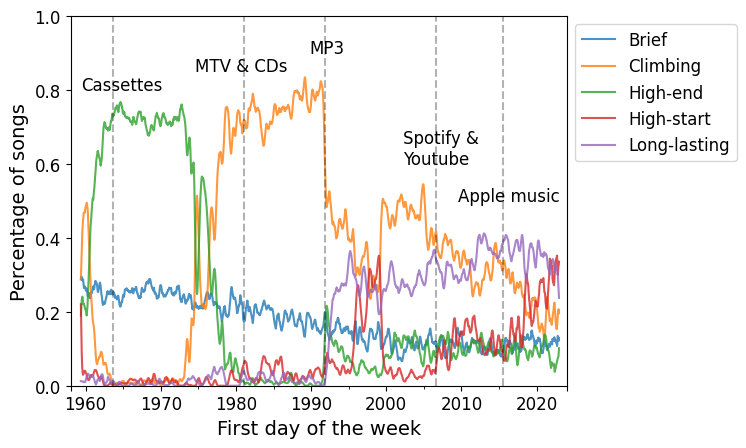

In [12]:
plt.figure(figsize=(6, 4))

billboard_hot_100_new_full_data = billboard_hot_100_new
billboard_hot_100_new_full_data.groupby(["first_day_of_the_week"])["cluster"].value_counts(
    normalize=True).unstack(fill_value=0).stack().sort_index().unstack().rolling(window=20).mean().plot(alpha=0.8)

plt.axvline(x = youtube_creation_date + timedelta(days=(spotify_creation_date - youtube_creation_date).days/2),
                                color='black', ls="dashed", alpha=0.3)
plt.axvline(x = apple_music_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = mtv_launch_date + timedelta(days=(mtv_launch_date - cds_creation_date).days/2), color='black',
                                ls="dashed", alpha=0.3)
plt.axvline(x = mp3_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = cassettes_creation_date, color="black", ls="dashed", alpha=0.3)

plt.text(youtube_creation_date - timedelta(weeks=150), 0.6, "Spotify &\nYoutube")
plt.text(apple_music_creation_date - timedelta(weeks=310), 0.5, "Apple music")
plt.text(mtv_launch_date - timedelta(weeks=370), 0.85, "MTV & CDs")
plt.text(mp3_creation_date - timedelta(weeks=110), 0.9, "MP3")
plt.text(cassettes_creation_date - timedelta(weeks=220), 0.8, "Cassettes")

plt.ylabel("Percentage of songs")
plt.xlabel("First day of the week")
plt.xlim(datetime(1958, 1, 1), datetime(2024, 1, 1))
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [13]:
import numpy as np
from scipy.stats import mannwhitneyu

billboard_hot_100_new_full_data = billboard_hot_100_new
data = billboard_hot_100_new_full_data.groupby(["first_day_of_the_week", "year"])["cluster"].value_counts(
    normalize=True).unstack(fill_value=0)

def slope_for_year_and_cluster(data, year, cluster):
    data_cluster = data[cluster]
    data_year = data_cluster[data_cluster.index.get_level_values("year") == int(year)]
    slope = np.polyfit(range(0, len(data_year.values)), data_year.values, 1)[0]
    return slope

important_years = ["1991", "1998", "2005", "2007", "2012", "2013", "2020"]

# Interpret
for year in important_years:
    for cluster in ["Brief", "High-start", "High-end", "Climbing", "Long-lasting"]:
        random_years = np.random.choice(data.index.get_level_values("year"), size=30, replace=False)
        slope = slope_for_year_and_cluster(data, year, cluster)
        abruptnessess_year = slope
        abruptness_random = [slope_for_year_and_cluster(data, x, cluster) for x in random_years]

        # Mann-Whitney U Test
        stat, p_value = mannwhitneyu([abruptnessess_year], abruptness_random, alternative='two-sided')

        if p_value <= 0.05:
            print("Significant difference in abruptness around " + cluster + " in " + year)
